In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import numpy as np

from Bio import Entrez
from Bio import ExPASy
from Bio import SwissProt
Entrez.email = "user@gmail.com"

### Get SCAN domain location

In [94]:
def fetch_uniprot_record(uniprot_id):
    with ExPASy.get_sprot_raw(uniprot_id) as handle:
        return SwissProt.read(handle)

def get_domain_indices(uniprot_record):
    domain_indices = {}
    for feature in uniprot_record.features:
        if feature.type == 'DOMAIN':
            domain_indices[feature.qualifiers['note']] = [feature.location.start, feature.location.end]
    return domain_indices

In [95]:
target_protein_uniprot = fetch_uniprot_record('P28698')
domains = get_domain_indices(target_protein_uniprot)

start_scan, end_scan = domains['SCAN box']

### Load in dataset

In [96]:
cmut = pd.read_csv('../data/cancermuts_MZF1.csv')
alphamissense = pd.read_csv('../data/alphamissense/P28698/alphamissense_P28698.tsv', sep='\t')

In [97]:
# Select only scan domain residues from cancermuts dataset

# Select subset of cmut, which contains only mutations in the SCAN box
cmut_scan = cmut[(cmut['aa_position'] >= start_scan) & (cmut['aa_position'] <= end_scan)]

# Drop all rows with missing values in alt_aa
cmut_scan = cmut_scan.dropna(subset=['alt_aa'])

# Reset index
cmut_scan = cmut_scan.reset_index(drop=True)

# Count number of rows
n_mutations = cmut_scan.shape[0]

In [98]:
P28698_energies = pd.read_csv('../data/mutatex/all_energies/P28698_scand_energies.csv')

In [99]:
O95125_complex_energies = pd.read_csv('../data/mutatex/all_energies/O95125_P28698_scand_complex_energies.csv')
P17028_complex_energies = pd.read_csv('../data/mutatex/all_energies/P17028_P28698_scand_complex_energies.csv')
P57086_complex_energies = pd.read_csv('../data/mutatex/all_energies/P57086_P28698_scand_complex_energies.csv')
Q15697_complex_energies = pd.read_csv('../data/mutatex/all_energies/Q15697_P28698_scand_complex_energies.csv')
Q8NBB4_complex_energies = pd.read_csv('../data/mutatex/all_energies/Q8NBB4_P28698_scand_complex_energies.csv')

# Add start_scan to Residue #
O95125_complex_energies['Residue #'] = O95125_complex_energies['Residue #'] + start_scan
P17028_complex_energies['Residue #'] = P17028_complex_energies['Residue #'] + start_scan
P57086_complex_energies['Residue #'] = P57086_complex_energies['Residue #'] + start_scan
Q15697_complex_energies['Residue #'] = Q15697_complex_energies['Residue #'] + start_scan
Q8NBB4_complex_energies['Residue #'] = Q8NBB4_complex_energies['Residue #'] + start_scan


In [100]:
energies_df_dict = {'P28698': P28698_energies,
                    'O95125_complex': O95125_complex_energies,
                    'P17028_complex': P17028_complex_energies,
                    'P57086_complex': P57086_complex_energies,
                    'Q15697_complex': Q15697_complex_energies,
                    'Q8NBB4_complex': Q8NBB4_complex_energies}


### Create a collection dataframe of mutations present in cmut and their ddgs in all the dataframe in energies_df_dict

In [101]:
cmut_mutations = []

# Get a list of mutation in cmut
for index, row in cmut_scan.iterrows():
    # Get the mutation
    mutation = row['ref_aa'] + str(row['aa_position']) + row['alt_aa']
    cmut_mutations.append(mutation)

# Create dataframe for the mutations
cmut_ddgs_df = pd.DataFrame(cmut_mutations, columns=['Mutation'])

# Left join alphamissense into cmut_ddgs_df
cmut_ddgs_df = cmut_ddgs_df.merge(alphamissense, how='left', left_on='Mutation', right_on='protein_variant')
cmut_ddgs_df = cmut_ddgs_df.drop(columns=['protein_variant', 'uniprot_id'])

# Loop over each protein structure and add ddgs for each mutation
for protein, energies_df in energies_df_dict.items():
    ddgs_protein = []
    for index, row in cmut_scan.iterrows():
        # Get the mutation
        ref_aa = row['ref_aa']
        mut_pos = row['aa_position']
        mut_aa = row['alt_aa']

        # Check if cmut mutation position is in the energies_df
        if mut_pos in energies_df['Residue #'].values:
            ddg_row = energies_df[energies_df['Residue #'] == mut_pos]
            
            # Get the ddg
            ddgs = float(ddg_row[mut_aa].values[0])
        else:
            ddgs = None
        
        ddgs_protein.append(ddgs)
        
    cmut_ddgs_df[protein] = ddgs_protein

# Set Mutation columns as indices
cmut_ddgs_df = cmut_ddgs_df.set_index('Mutation')
cmut_ddgs_df

,am_pathogenicity,am_class,P28698,O95125_complex,P17028_complex,P57086_complex,Q15697_complex,Q8NBB4_complex
Mutation,,,,,,,,
R44C,0.1503,benign,0.83912,NaN,NaN,NaN,NaN,NaN
R44H,0.1246,benign,1.80213,NaN,NaN,NaN,NaN,NaN
L45M,0.1707,benign,-0.07550,NaN,NaN,NaN,NaN,NaN
R46C,0.1186,benign,0.98232,-0.09436,NaN,NaN,NaN,-0.03966
R46H,0.1005,benign,0.86302,-0.05064,NaN,NaN,NaN,-0.06200
F47S,0.9650,pathogenic,2.79973,0.85252,0.62924,0.88926,1.01862,1.04646
R48Q,0.1145,benign,0.77259,1.85362,0.29102,-0.95392,1.29436,0.36134
R48W,0.1493,benign,0.51392,0.84176,-0.67036,-1.21282,1.28664,-0.74100
R51H,0.0848,benign,0.67379,-0.09178,0.00292,-0.08164,-0.04558,0.09058


### Heatmapping cancermut

Text(904.4444444444445, 0.5, '')

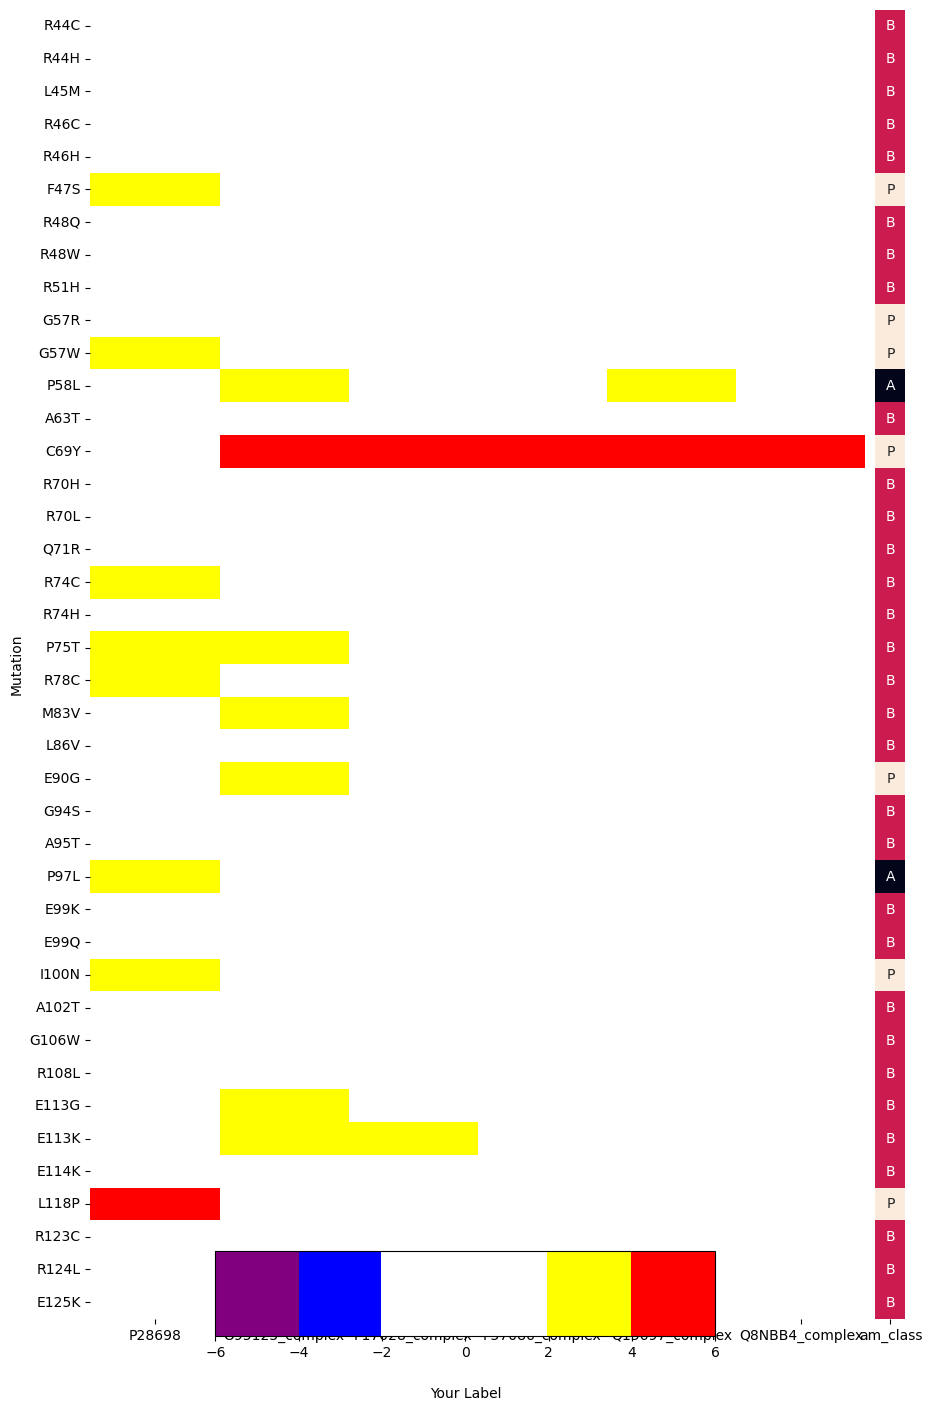

In [102]:
# Get protein from cmut_ddgs_df
proteins = cmut_ddgs_df.columns[2:].values

# Create a mapping from categories to letters
mapping = {'benign': 'B', 'ambiguous': 'A', 'pathogenic': 'P'}

# Create a reverse mapping from letters to integer values
def reverse_map(x):
    reverse_map_dict = {'A': 0,
                        'B': 1,
                        'P': 2}
    for key, value in reverse_map_dict.items():
        if x == key:
            return value


# Apply the mapping to the 'pathogenicity_class' column
cmut_ddgs_df['am_class'] = cmut_ddgs_df['am_class'].map(mapping)

plt.figure(figsize=(10, 17))

#
#colors = ["purple", "blue", "white", "yellow", "red"]
#bounds = np.array([-np.inf, -5, -2, 2, 5, np.inf])

# Define custom color mapping
colors = sns.color_palette(["purple", "blue", "white", "white", "yellow", "red"])
thresholds = [-np.inf, -2, 0, 2, 5, np.inf]

ax1 = sns.heatmap(cmut_ddgs_df[proteins], cmap=colors, center=0, cbar=False, vmin=-6, vmax=6)

# Create a new axis for the colorbar at the bottom of the figure
cbar_ax = plt.gcf().add_axes([0.25, 0.1, 0.5, 0.05])

# Create the colorbar
cbar = plt.colorbar(ax1.collections[0], cax=cbar_ax, orientation='horizontal')

# Set the label for the colorbar
cbar.set_label('Your Label', rotation=0, labelpad=20)



# Create a new axis for the second heatmap
ax2 = plt.gcf().add_axes([.91, ax1.get_position().y0, .03, ax1.get_position().height])

# Create the second heatmap for the 'pathogenicity_class' column
sns.heatmap(cmut_ddgs_df['am_class'].apply(lambda x: reverse_map(x)).to_frame(), annot=cmut_ddgs_df[['am_class']], fmt='', cbar=False, yticklabels=False, ax=ax2)

# Remove y-axis label for the second heatmap
ax2.set_ylabel('')

# Full saturation

### Select stabilizing or destabilizing mutations

In [103]:
amino_acids = target_protein_ddgs.columns[3:].values

NameError: name 'target_protein_ddgs' is not defined

In [ ]:
# Keep only rows with values above 2 or below -2 in amino_acids columns
target_protein_ddgs_thresholded = target_protein_ddgs[target_protein_ddgs[amino_acids].apply(lambda x: x.abs() > 2).any(axis=1)]
target_protein_ddgs_thresholded

,WT residue type,chain ID,Residue #,G,A,V,L,I,M,F,...,T,C,Y,N,Q,D,E,K,R,H
3,F,A,47,3.42244,2.13592,1.77024,-0.02192,1.80926,0.20279,-0.00280,...,2.66995,2.25383,0.32704,2.69600,1.77852,3.38536,2.65121,1.35347,1.58603,2.20909
4,R,A,48,1.31879,0.88199,1.20100,0.17514,0.74971,-0.12878,0.80316,...,1.03416,0.78517,0.64717,0.07568,0.77259,0.95081,0.66792,0.05241,-0.00373,1.14795
5,C,A,49,0.34146,0.27020,0.86087,-0.62206,0.42207,-0.60659,-0.40163,...,0.22744,-0.01246,-0.42019,-0.12575,-0.10587,0.20885,0.01121,-0.25369,-0.39015,0.07064
6,F,A,50,4.76570,3.98788,3.85820,1.94493,3.02370,1.51393,-0.01452,...,3.40208,3.78489,1.69770,4.24162,3.85825,5.22674,4.78152,3.55783,4.60678,3.38200
10,E,A,54,1.81854,1.15818,1.96924,0.13339,1.50806,0.18300,0.44957,...,0.71204,1.18795,0.65055,0.66940,0.53608,0.19198,-0.05606,0.79324,1.11500,1.29404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,D,A,120,0.44441,-0.32840,-0.16155,-0.90871,-0.67685,-1.21087,-0.81166,...,-0.36068,0.11618,-0.73722,-0.46974,-0.38918,-0.00106,-0.52250,-0.59462,-0.88843,-0.06133
77,G,A,121,0.00000,-0.96237,-0.69805,-1.39964,-1.28458,-2.05061,-1.18047,...,-0.40916,-0.07043,-1.17149,-0.62107,-1.26949,-0.02438,-0.70323,-1.19639,-1.13339,-0.47717
78,L,A,122,3.26117,1.69376,2.74528,-0.00846,1.33506,0.04320,-0.25410,...,2.67839,2.34500,0.95772,1.94982,2.73183,3.64249,2.82995,1.93052,1.93091,1.78189
79,R,A,123,0.85712,0.70247,1.84200,0.35544,1.48981,-0.05607,0.04893,...,1.71708,0.95158,0.13445,1.06764,0.50416,2.19407,1.36348,0.18090,0.00258,0.34266
